In [1]:
import pathlib

import polars as pl
import polars.selectors as cs

In [2]:
raw_dirpath = pathlib.Path("../data/raw")

train = pl.read_csv(raw_dirpath / "train.csv")
test = pl.read_csv(raw_dirpath / "test.csv")
submission = pl.read_csv(raw_dirpath / "sample_submission.csv")
concepts = pl.read_csv(raw_dirpath / "concepts.csv")

## Target

<Axes: >

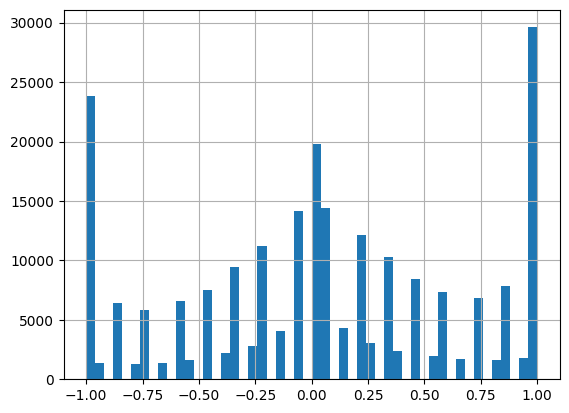

In [3]:
target = train.select(pl.col("utility_agent1")).to_pandas()

target["utility_agent1"].hist(bins=50)

In [ ]:
target.value_counts().sort_index()

utility_agent1
-1.000000         23846
-0.966667             6
-0.955556             1
-0.933333          1343
-0.900000             7
                  ...  
 0.900000             8
 0.933333          1771
 0.955556             1
 0.966667             6
 1.000000         29604
Name: count, Length: 68, dtype: int64

In [5]:
(target == 1.0).sum()

utility_agent1    29604
dtype: int64

In [6]:
(target.abs() != 1.0).sum()

utility_agent1    179784
dtype: int64

In [7]:
(target == -1).sum()

utility_agent1    23846
dtype: int64

In [8]:
result_agent1 = train.select(
    pl.col(
        [
            "num_wins_agent1",
            "num_draws_agent1",
            "num_losses_agent1",
            "utility_agent1",
        ]
    )
)

result_agent1

shape: (233_234, 4)
┌─────────────────┬──────────────────┬───────────────────┬────────────────┐
│ num_wins_agent1 ┆ num_draws_agent1 ┆ num_losses_agent1 ┆ utility_agent1 │
│ ---             ┆ ---              ┆ ---               ┆ ---            │
│ i64             ┆ i64              ┆ i64               ┆ f64            │
╞═════════════════╪══════════════════╪═══════════════════╪════════════════╡
│ 4               ┆ 0                ┆ 11                ┆ -0.466667      │
│ 5               ┆ 0                ┆ 10                ┆ -0.333333      │
│ 7               ┆ 0                ┆ 8                 ┆ -0.066667      │
│ 5               ┆ 0                ┆ 10                ┆ -0.333333      │
│ 5               ┆ 0                ┆ 10                ┆ -0.333333      │
│ …               ┆ …                ┆ …                 ┆ …              │
│ 2               ┆ 0                ┆ 13                ┆ -0.733333      │
│ 9               ┆ 1                ┆ 5                 ┆ 0.266667       │
│ 11              ┆ 3                ┆ 1                 ┆ 0.666667       │
│ 24              ┆ 2                ┆ 4                 ┆ 0.666667       │
│ 9               ┆ 1                ┆ 5                 ┆ 0.266667       │
└─────────────────┴──────────────────┴───────────────────┴────────────────┘

In [9]:
(result_agent1["num_wins_agent1"] == 0.0).sum()

47010

In [10]:
(result_agent1["num_losses_agent1"] == 0.0).sum()

55330

## Features

In [11]:
# 情報量が少ないカラムを特定する


def count_low_unique_cols(df: pl.DataFrame, threshold: int = 1) -> int:
    unique_counts = df.select([pl.col(name).n_unique() for name in df.columns])
    return sum(
        1 for count in unique_counts.to_numpy().flatten() if count <= threshold
    )


for i in range(1, 10):
    num_unique_one_columns = count_low_unique_cols(train, i)
    print(
        "値が {} つしかないカラムの数: {} / {}".format(
            i, num_unique_one_columns, len(train.columns)
        )
    )

値が 1 つしかないカラムの数: 216 / 814
値が 2 つしかないカラムの数: 598 / 814
値が 3 つしかないカラムの数: 612 / 814
値が 4 つしかないカラムの数: 623 / 814
値が 5 つしかないカラムの数: 627 / 814
値が 6 つしかないカラムの数: 634 / 814
値が 7 つしかないカラムの数: 638 / 814
値が 8 つしかないカラムの数: 641 / 814
値が 9 つしかないカラムの数: 642 / 814


In [12]:
def get_low_unique_cols(df: pl.DataFrame, threshold: int = 1) -> list[str]:
    unique_counts = df.select([pl.col(name).n_unique() for name in df.columns])
    return [
        name
        for name, count in zip(df.columns, unique_counts.to_numpy().flatten())
        if count <= threshold
    ]


low_unique_cols = get_low_unique_cols(train, 1)

train = train.drop(low_unique_cols)

In [13]:
# 型が数値のカラムを特定する


def get_numeric_cols(df: pl.DataFrame) -> list[str]:
    return df.select(cs.numeric()).columns


numeric_cols = get_numeric_cols(train)
print("型が数値のカラムの数:", len(numeric_cols))


train.select(numeric_cols).describe()

型が数値のカラムの数: 593


shape: (9, 594)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Id        ┆ Stochasti ┆ Asymmetri ┆ … ┆ num_wins_ ┆ num_draws ┆ num_losse ┆ utility_ │
│ ---       ┆ ---       ┆ c         ┆ c         ┆   ┆ agent1    ┆ _agent1   ┆ s_agent1  ┆ agent1   │
│ str       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 233234.0  ┆ 233234.0  ┆ 233234.0  ┆ … ┆ 233234.0  ┆ 233234.0  ┆ 233234.0  ┆ 233234.0 │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 116616.5  ┆ 0.075829  ┆ 0.186474  ┆ … ┆ 6.759735  ┆ 2.333528  ┆ 6.087586  ┆ 0.044398 │
│ std       ┆ 67329.000 ┆ 0.264726  ┆ 0.389489  ┆ … ┆ 5.377815  ┆ 4.625684  ┆ 5.272134  ┆ 0.622847 │
│           ┆ 679       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ min       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ -1.0     │
│ 25%       ┆ 58308.0   ┆ 0.0       ┆ 0.0       ┆ … ┆ 1.0       ┆ 0.0       ┆ 1.0       ┆ -0.33333 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3        │
│ 50%       ┆ 116617.0  ┆ 0.0       ┆ 0.0       ┆ … ┆ 6.0       ┆ 0.0       ┆ 6.0       ┆ 0.0      │
│ 75%       ┆ 174925.0  ┆ 0.0       ┆ 0.0       ┆ … ┆ 11.0      ┆ 2.0       ┆ 10.0      ┆ 0.533333 │
│ max       ┆ 233233.0  ┆ 1.0       ┆ 1.0       ┆ … ┆ 44.0      ┆ 30.0      ┆ 45.0      ┆ 1.0      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [14]:
display(concepts)
display(concepts.describe())

shape: (809, 9)
┌─────┬─────────────┬─────────────┬────────┬───┬─────────────┬─────────────┬──────────┬────────────┐
│ Id  ┆ Name        ┆ Description ┆ TypeId ┆ … ┆ Computation ┆ TaxonomyStr ┆ LeafNode ┆ ShowOnWebs │
│ --- ┆ ---         ┆ ---         ┆ ---    ┆   ┆ TypeId      ┆ ing         ┆ ---      ┆ ite        │
│ i64 ┆ str         ┆ str         ┆ i64    ┆   ┆ ---         ┆ ---         ┆ i64      ┆ ---        │
│     ┆             ┆             ┆        ┆   ┆ i64         ┆ str         ┆          ┆ i64        │
╞═════╪═════════════╪═════════════╪════════╪═══╪═════════════╪═════════════╪══════════╪════════════╡
│ 1   ┆ Properties  ┆ General     ┆ 1      ┆ … ┆ 1           ┆ 1           ┆ 0        ┆ 0          │
│     ┆             ┆ properties  ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆             ┆ of the      ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆             ┆ game…       ┆        ┆   ┆             ┆             ┆          ┆            │
│ 2   ┆ Format      ┆ Format of   ┆ 1      ┆ … ┆ 1           ┆ 1.1         ┆ 0        ┆ 0          │
│     ┆             ┆ the game.   ┆        ┆   ┆             ┆             ┆          ┆            │
│ 3   ┆ Time        ┆ Time model. ┆ 1      ┆ … ┆ 1           ┆ 1.1.1       ┆ 0        ┆ 0          │
│ 4   ┆ Discrete    ┆ Players     ┆ 1      ┆ … ┆ 1           ┆ 1.1.1.1     ┆ 1        ┆ 1          │
│     ┆             ┆ move at     ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆             ┆ discrete    ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆             ┆ inter…      ┆        ┆   ┆             ┆             ┆          ┆            │
│ 5   ┆ Realtime    ┆ Moves not   ┆ 1      ┆ … ┆ 1           ┆ 1.1.1.2     ┆ 1        ┆ 1          │
│     ┆             ┆ discrete.   ┆        ┆   ┆             ┆             ┆          ┆            │
│ …   ┆ …           ┆ …           ┆ …      ┆ … ┆ …           ┆ …           ┆ …        ┆ …          │
│ 805 ┆ SkillTrace  ┆ Skill       ┆ 7      ┆ … ┆ 2           ┆ 4.13        ┆ 0        ┆ 1          │
│     ┆             ┆ Trace.      ┆        ┆   ┆             ┆             ┆          ┆            │
│ 806 ┆ SkillTraceS ┆ Skill Trace ┆ 7      ┆ … ┆ 2           ┆ 4.13.1      ┆ 1        ┆ 1          │
│     ┆ core        ┆ Score.      ┆        ┆   ┆             ┆             ┆          ┆            │
│ 807 ┆ SkillTraceT ┆ Skill Trace ┆ 7      ┆ … ┆ 2           ┆ 4.13.2      ┆ 1        ┆ 1          │
│     ┆ rials       ┆ Trials.     ┆        ┆   ┆             ┆             ┆          ┆            │
│ 808 ┆ SkillTraceE ┆ Skill Trace ┆ 7      ┆ … ┆ 2           ┆ 4.13.3      ┆ 1        ┆ 1          │
│     ┆ rrorSlope   ┆ Error       ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆             ┆ Slope.      ┆        ┆   ┆             ┆             ┆          ┆            │
│ 809 ┆ SkillTraceE ┆ Skill Trace ┆ 7      ┆ … ┆ 2           ┆ 4.13.4      ┆ 1        ┆ 1          │
│     ┆ rrorInterce ┆ Error       ┆        ┆   ┆             ┆             ┆          ┆            │
│     ┆ pt          ┆ Intercept.  ┆        ┆   ┆             ┆             ┆          ┆            │
└─────┴─────────────┴─────────────┴────────┴───┴─────────────┴─────────────┴──────────┴────────────┘

shape: (9, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ statistic ┆ Id        ┆ Name      ┆ Descripti ┆ … ┆ Computati ┆ TaxonomyS ┆ LeafNode ┆ ShowOnWeb │
│ ---       ┆ ---       ┆ ---       ┆ on        ┆   ┆ onTypeId  ┆ tring     ┆ ---      ┆ site      │
│ str       ┆ f64       ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64      ┆ ---       │
│           ┆           ┆           ┆ str       ┆   ┆ f64       ┆ str       ┆          ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ count     ┆ 809.0     ┆ 809       ┆ 809       ┆ … ┆ 809.0     ┆ 809       ┆ 809.0    ┆ 809.0     │
│ null_coun ┆ 0.0       ┆ 0         ┆ 0         ┆ … ┆ 0.0       ┆ 0         ┆ 0.0      ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ mean      ┆ 405.0     ┆ null      ┆ null      ┆ … ┆ 1.368356  ┆ null      ┆ 0.702101 ┆ 0.978986  │
│ std       ┆ 233.68247 ┆ null      ┆ null      ┆ … ┆ 0.482657  ┆ null      ┆ 0.457618 ┆ 0.143518  │
│           ┆ 7         ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ min       ┆ 1.0       ┆ Absolute  ┆ !=        ┆ … ┆ 1.0       ┆ 1         ┆ 0.0      ┆ 0.0       │
│           ┆           ┆           ┆ operator. ┆   ┆           ┆           ┆          ┆           │
│ 25%       ┆ 203.0     ┆ null      ┆ null      ┆ … ┆ 1.0       ┆ null      ┆ 0.0      ┆ 1.0       │
│ 50%       ┆ 405.0     ┆ null      ┆ null      ┆ … ┆ 1.0       ┆ null      ┆ 1.0      ┆ 1.0       │
│ 75%       ┆ 607.0     ┆ null      ┆ null      ┆ … ┆ 2.0       ┆ null      ┆ 1.0      ┆ 1.0       │
│ max       ┆ 809.0     ┆ XiangqiSt ┆ Win with  ┆ … ┆ 2.0       ┆ 7.2.7     ┆ 1.0      ┆ 1.0       │
│           ┆           ┆ yle       ┆ a path    ┆   ┆           ┆           ┆          ┆           │
│           ┆           ┆           ┆ extent.   ┆   ┆           ┆           ┆          ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴──────────┴───────────┘

## LudRules の分析

In [15]:
tmp = train.select(pl.col("LudRules")).to_numpy().flatten()

In [16]:
import re


def parse_game_definition(game_string: str):
    game_dict = {}

    # ゲーム名の抽出
    game_name_match = re.search(r'\(game "(.*?)"', game_string)
    if game_name_match:
        game_dict["name"] = game_name_match.group(1)

    # プレイヤー数の抽出
    players_match = re.search(r"\(players (\d+)\)", game_string)
    if players_match:
        game_dict["players"] = int(players_match.group(1))

    # equipment, rules, endの抽出
    for section in ["equipment", "rules", "end"]:
        pattern = rf"\({section} ({{.*?}})\)"
        match = re.search(pattern, game_string, re.DOTALL)
        if match:
            game_dict[section] = match.group(1)

    return game_dict

In [17]:
train.head()

shape: (5, 598)
┌─────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ Id  ┆ GameRulese ┆ agent1     ┆ agent2     ┆ … ┆ num_wins_a ┆ num_draws_ ┆ num_losse ┆ utility_a │
│ --- ┆ tName      ┆ ---        ┆ ---        ┆   ┆ gent1      ┆ agent1     ┆ s_agent1  ┆ gent1     │
│ i64 ┆ ---        ┆ str        ┆ str        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│     ┆ str        ┆            ┆            ┆   ┆ i64        ┆ i64        ┆ i64       ┆ f64       │
╞═════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0   ┆ 00Y        ┆ MCTS-Progr ┆ MCTS-Progr ┆ … ┆ 4          ┆ 0          ┆ 11        ┆ -0.466667 │
│     ┆            ┆ essiveHist ┆ essiveHist ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ ory-0.1-MA ┆ ory-0.6-Ra ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ …          ┆ …          ┆   ┆            ┆            ┆           ┆           │
│ 1   ┆ 00Y        ┆ MCTS-Progr ┆ MCTS-UCB1G ┆ … ┆ 5          ┆ 0          ┆ 10        ┆ -0.333333 │
│     ┆            ┆ essiveHist ┆ RAVE-0.6-N ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ ory-0.1-MA ┆ ST-true    ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ …          ┆            ┆   ┆            ┆            ┆           ┆           │
│ 2   ┆ 00Y        ┆ MCTS-Progr ┆ MCTS-UCB1- ┆ … ┆ 7          ┆ 0          ┆ 8         ┆ -0.066667 │
│     ┆            ┆ essiveHist ┆ 0.1-NST-fa ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ ory-0.1-MA ┆ lse        ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ …          ┆            ┆   ┆            ┆            ┆           ┆           │
│ 3   ┆ 00Y        ┆ MCTS-Progr ┆ MCTS-UCB1- ┆ … ┆ 5          ┆ 0          ┆ 10        ┆ -0.333333 │
│     ┆            ┆ essiveHist ┆ 0.6-NST-fa ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ ory-0.1-MA ┆ lse        ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ …          ┆            ┆   ┆            ┆            ┆           ┆           │
│ 4   ┆ 00Y        ┆ MCTS-Progr ┆ MCTS-UCB1G ┆ … ┆ 5          ┆ 0          ┆ 10        ┆ -0.333333 │
│     ┆            ┆ essiveHist ┆ RAVE-1.414 ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ ory-0.1-MA ┆ 21356237-N ┆   ┆            ┆            ┆           ┆           │
│     ┆            ┆ …          ┆ …          ┆   ┆            ┆            ┆           ┆           │
└─────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [18]:
for idx, row in (
    (
        train.select([c for c in train.columns if train[c].n_unique() > 1])
        .select(pl.all().n_unique())
        .to_pandas()
        .T
    )
    .head()
    .iterrows()
):
    print(idx, row[0])

Id 233234
GameRulesetName 1377
agent1 72
agent2 72
Stochastic 2


### GameRulesetName

In [29]:
train.select(pl.col("LudRules")).n_unique()

1373

In [48]:
train.select(
    pl.col("LudRules")
    .str.extract(r"equipment \{ \((\w+) ", 1)
    .alias("equipment")
).unique()

shape: (5, 1)
┌────────────────┐
│ equipment      │
│ ---            │
│ str            │
╞════════════════╡
│ board          │
│ piece          │
│ surakartaBoard │
│ boardless      │
│ mancalaBoard   │
└────────────────┘

In [51]:
train.select(
    pl.col("LudRules")
    .str.extract(r"equipment \{ \((\w+) ", 1)
    .replace_strict(
        {
            "board": 0,
            "piece": 1,
            "surakartaBoard": 2,
            "boardless": 3,
            "mancalaBoard": 4,
        },
        default=-1,
    )
    .alias("equipment")
).to_pandas().value_counts()

equipment
0            191368
4             40622
3               904
2               184
1               156
Name: count, dtype: int64

In [31]:
for s in train["LudRules"].unique().to_list():
    print(s)
    print("\n\n")

(game "Tugi-Epfe" (players 2) (equipment { (board (merge { (rectangle 1 11) (rectangle 11 1) (shift 0 10 (rectangle 1 11)) (shift 10 0 (rectangle 11 1)) } ) { (track "TrackCW" { 0 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 39 38 37 36 35 34 33 32 31 30 9 8 7 6 5 4 3 2 1 0 } directed:True ) (track "TrackCCW" { 0 1 2 3 4 5 6 7 8 9 30 31 32 33 34 35 36 37 38 39 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 0 } directed:True ) } use:Edge ) (dice d:2 facesByDie:{ { 0 10} { 0 1 } { 0 1 } } num:3) (map "ThrowDiceValue" { (pair 0 5) (pair 12 5) (pair 2 1) (pair 1 3) (pair 10 15) (pair 11 15) } ) (piece "Horse" Each (if (= (value Player Mover) Off) (or (if (!= (trackSite Move "TrackCW" steps:(mapEntry "ThrowDiceValue" (count Pips) ) ) Off ) (if (or (is Empty (trackSite Move "TrackCW" steps:(mapEntry "ThrowDiceValue" (count Pips) ) ) ) (and (is Enemy (who at:(trackSite Move "TrackCW" steps:(mapEntry "ThrowDiceValue" (count Pips) ) ) ) ) (or (= (value Player Mover) 

## Player feature

In [69]:
train.select(
    pl.col("^.*P1.*$"),
    pl.col("^.*p1.*$"),
    pl.col("^.*P2.*$"),
    pl.col("^.*p2.*$"),
).head()

shape: (5, 1)
┌─────────────┐
│ AdvantageP1 │
│ ---         │
│ f64         │
╞═════════════╡
│ 0.5         │
│ 0.5         │
│ 0.5         │
│ 0.5         │
│ 0.5         │
└─────────────┘

In [39]:
train.select(
    pl.col("AdvantageP1"),
    (1 - pl.col("AdvantageP1")).alias("AdvantageP2"),
)

shape: (233_234, 2)
┌─────────────┬─────────────┐
│ AdvantageP1 ┆ AdvantageP2 │
│ ---         ┆ ---         │
│ f64         ┆ f64         │
╞═════════════╪═════════════╡
│ 0.5         ┆ 0.5         │
│ 0.5         ┆ 0.5         │
│ 0.5         ┆ 0.5         │
│ 0.5         ┆ 0.5         │
│ 0.5         ┆ 0.5         │
│ …           ┆ …           │
│ 0.49        ┆ 0.51        │
│ 0.49        ┆ 0.51        │
│ 0.49        ┆ 0.51        │
│ 0.49        ┆ 0.51        │
│ 0.49        ┆ 0.51        │
└─────────────┴─────────────┘

In [63]:
train.select(pl.col("^.*P2.*$")).head()

shape: (0, 0)
┌┐
╞╡
└┘